<b>Исследование синхронизации нейроморфных сетей тесного мира.</b>

Участники:\
    Пеганов Никита\
    Диана Мустаева\
    Роман Головин

In [64]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

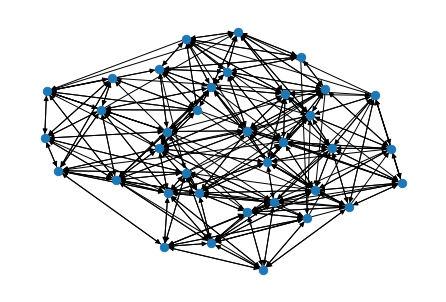

In [94]:
side = 6
sw = nx.navigable_small_world_graph(side, p=2, q=5)
options = {
#     'node_color': 'black',
    'node_size': 70,
    'width': 1,
}
nx.draw(sw, **options)

In [95]:
def vertex_num(vertex):
    return vertex[0] * 6 + vertex[1]

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import brian2 as b2
import numpy as np
import random

def plot_v_spikes(v_mon, s_mon, t_bounds=None, names=None):
    b2.figure(figsize=(12,4))
    b2.subplot(121)
    for i in range(len(v_mon.v)):
        if names:
            b2.plot(v_mon.t/b2.ms, v_mon.v[i], label=names[i])
        else:
            b2.plot(v_mon.t/b2.ms, v_mon.v[i], label=f'N_{i}')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend();
    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num') 

N = side ** 2
V_REST = 1.5
TAU_V = 15 * b2.ms
V_RESET = 0
VT_0 = 1
TAU_T = 40 * b2.ms
THETA = 0.7
W_SYN = -1.5

def alif_group(num_neurons, v_rest=V_REST,tau_v=TAU_V, 
               v_reset=V_RESET, vt_0=VT_0, 
               tau_t=TAU_T, theta=THETA):
    eqs = '''
        dv/dt = (v_rest-v)/tau_v: 1
        dvt/dt = (vt_0-vt)/tau_t : 1
        tau_v : second
        v_rest : 1
        v_reset : 1
        vt_0 : 1
        tau_t : second
        theta : 1
        '''
    reset = '''
        v = v_reset
        vt += theta
        '''
    taurefr = 2*b2.ms
    G = b2.NeuronGroup(num_neurons, model=eqs, reset=reset, threshold='v>vt',
                 method='linear', refractory=taurefr)
    G.tau_v = tau_v
    G.v_rest = v_rest
    G.v_reset = v_reset
    G.vt_0 = 'rand()'
    G.tau_t = tau_t
    G.theta = theta
    G.vt = v_rest
    return G

#def period(s_mon):
    

class CPG:
    
    def __init__(self):
        self.N = N
        self.neurons = alif_group(self.N)
        self.spike_mon = b2.SpikeMonitor(self.neurons)
        self.v_mon = b2.StateMonitor(self.neurons, ["v", "vt"], record=True)
        self.pop_mon = b2.PopulationRateMonitor(self.neurons)
        self.create_synapses()
        self.net = b2.Network(self.neurons, self.synapses, self.spike_mon, self.v_mon, self.pop_mon)
            
    def create_synapses(self):
        self.synapses = b2.Synapses(self.neurons, self.neurons, on_pre='v_post += w_syn')
        for edge in sw.edges:
            self.synapses.connect(i=vertex_num(edge[0]), j=vertex_num(edge[1]))
        

In [97]:
b2.start_scope()
cpg = CPG()
#PG = b2.PoissonGroup(1, 10*1/TAU_V)
cpg.net.run(500 * b2.ms, namespace={'w_syn':W_SYN})

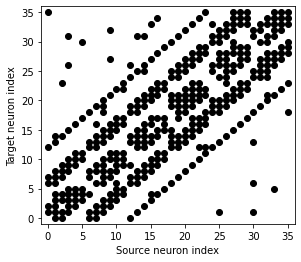

In [103]:
# визуализация связей между нейронами
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    plt.figure(figsize=(10, 4))
    plt.xticks([0, 1], ['Source', 'Target'])
    plt.ylabel('Neuron index')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-1, max(Ns, Nt))
    plt.subplot(122)
    plt.plot(S.i, S.j, 'ok')
    plt.xlim(-1, Ns)
    plt.ylim(-1, Nt)
    plt.xlabel('Source neuron index')
    plt.ylabel('Target neuron index')

visualise_connectivity(cpg.synapses)

(0.0, 500.0)

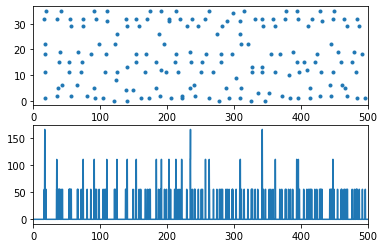

In [98]:
duration = 500 * b2.ms
plt.subplot(211)
plt.plot(cpg.spike_mon.t/b2.ms, cpg.spike_mon.i, '.')
plt.xlim(0, duration/b2.ms)

LFP = cpg.pop_mon

plt.subplot(212)
plt.plot(LFP.t/b2.ms, LFP.smooth_rate(window='flat', width=0.5*b2.ms)/b2.Hz)
plt.xlim(0, duration/b2.ms)